In [1]:
from scipy import io
from scipy.signal import butter, lfilter
from scipy import signal

import h5py
import random
import numpy as np
import os

import datetime
from time import gmtime, strftime, time

from nd_legacy import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from bot_slacker import send_slack_message, send_slack_picture
send_slack_message("test (startup)")

### Load data

In [4]:
ecog_matfile = io.loadmat('test_ecog_data.mat')
raw_data = ecog_matfile['raw_data']
raw_acc = ecog_matfile['raw_acc']
mv_acc = ecog_matfile['mv_acc']

sampling_rate = 2000

raw_data = raw_data[:,0:-10000]
raw_acc = raw_acc[:,0:-10000]
mv_acc = mv_acc[:,0:-10000]

print(raw_data.shape)
print(raw_acc.shape)
print(mv_acc.shape)

len_raw_data = raw_data.shape[1]
print(len_raw_data)

(12, 126001)
(1, 126001)
(1, 126001)
126001


In [5]:
chan_names = ecog_matfile['chan_names']

chan_names = chan_names[0]
chan_names = chan_names.tolist()
for i in range(len(chan_names)):
  chan_names[i] = chan_names[i][0]

print(chan_names)

['P3_1_d', 'P3_2_d', 'F3_1_d', 'F3_2_d', 'C3_1_d', 'C3_2_d', 'C3_3_d', 'C3_4_d', 'T5_1_d', 'T5_2_d', 'T5_3_d', 'T5_4_d']


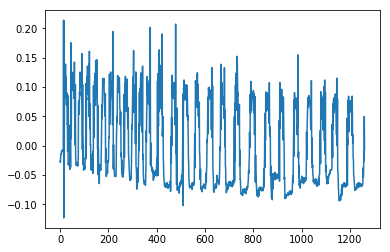

In [6]:
plt.plot(raw_acc[0,::100])

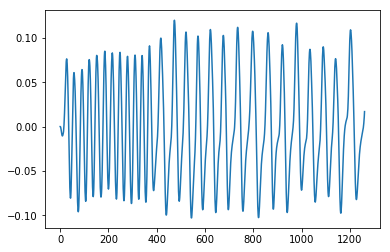

In [7]:
raw_acc_f = butter_bandpass_filter(raw_acc, 0.1, 1, sampling_rate, order=3, how_to_filt = 'separately')
raw_acc_f.shape
plt.plot(raw_acc_f[0,::100])

### Convert to spectrogram

In [95]:
f, t, raw_data_spec = signal.spectrogram(raw_data[4:8,:].T, fs=2000, nperseg=500, noverlap=499, axis = 0, mode="complex")

In [96]:
raw_acc_f_spec = raw_acc_f[:,499:]
raw_acc_f_spec.shape

(1, 125502)

In [97]:
raw_data_spec = abs(raw_data_spec)
raw_data_spec = np.swapaxes(raw_data_spec,1,2)
raw_data_spec = raw_data_spec[:50,:,:]
f = f[:50]

In [98]:
len_raw_data_spec = raw_data_spec.shape[1]

In [99]:
raw_data_train = raw_data[4:8,0:(len_raw_data//2)]
raw_data_val = raw_data[4:8,(len_raw_data//2):(2*len_raw_data//3)]
raw_data_test = raw_data[4:8,(2*len_raw_data//3):(-1000)]

#mv_acc_train = mv_acc[:,0:(len_raw_data//2)]
#mv_acc_val = mv_acc[:,(len_raw_data//2):(2*len_raw_data//3)]
#mv_acc_test = mv_acc[:,(2*len_raw_data//3):]

mv_acc_train = raw_acc_f[:,0:(len_raw_data//2)]
mv_acc_val = raw_acc_f[:,(len_raw_data//2):(2*len_raw_data//3)]
mv_acc_test = raw_acc_f[:,(2*len_raw_data//3):(-1000)]

raw_data_train_spec = raw_data_spec[:,0:(len_raw_data_spec//2)]
raw_data_val_spec = raw_data_spec[:,(len_raw_data_spec//2):(2*len_raw_data_spec//3)]
raw_data_test_spec = raw_data_spec[:,(2*len_raw_data_spec//3):(-1000)]

mv_acc_train_spec = raw_acc_f_spec[:,0:(len_raw_data_spec//2)]
mv_acc_val_spec = raw_acc_f_spec[:,(len_raw_data_spec//2):(2*len_raw_data_spec//3)]
mv_acc_test_spec = raw_acc_f_spec[:,(2*len_raw_data_spec//3):(-1000)]

#### check dimensions

In [100]:
print(mv_acc_train_spec.shape)
print(raw_data_train_spec.shape)
print("\n")
print(raw_data_val_spec.shape)
print(mv_acc_val_spec.shape)
print("\n")
print(raw_data_test_spec.shape)
print(mv_acc_test_spec.shape)
print("\n")
print(raw_data_spec.shape)
print(raw_acc_f_spec.shape)

(1, 62751)
(50, 62751, 4)


(50, 20917, 4)
(1, 20917)


(50, 40834, 4)
(1, 40834)


(50, 125502, 4)
(1, 125502)


In [101]:
print(raw_data_train.shape)
print(mv_acc_train.shape)

print(raw_data_val.shape)
print(mv_acc_val.shape)

print(raw_data_test.shape)
print(mv_acc_test.shape)

(4, 63000)
(1, 63000)
(4, 21000)
(1, 21000)
(4, 41001)
(1, 41001)


In [9]:
#plt.plot(8*raw_acc_f[0,::10],'b',mv_acc[0,::10],'g')

### Functions for data generation (to fit with fit_generator)

In [104]:
def generate_slice_fromspec(slice_len, val=False, test=False):
    if val:
        X = raw_data_val_spec
        y = mv_acc_val_spec
    elif ~test:
        X = raw_data_train_spec
        y = mv_acc_train_spec
    else:
        X = raw_data_test_spec
        y = mv_acc_test_spec
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_x = X[:,slice_start:slice_end,:]
        slice_y = y[0,slice_end]
            
        return slice_x, slice_y

In [105]:
testx, testy = generate_slice_fromspec(2000)

In [106]:
testx.shape

(50, 2000, 4)

In [46]:
def generate_slice(slice_len, val=False, spec=False, test=False):
    if val:
        X = raw_data_val
        y = mv_acc_val
    elif ~test:
        X = raw_data_train
        y = mv_acc_train
    else:
        X = raw_data_test
        y = mv_acc_test
    
    len_X = X.shape[1]
    
    while True:
        slice_start = np.random.choice(len_X - slice_len)
        slice_end = slice_start + slice_len
        slice_x_raw = X[:,slice_start:slice_end].T
        slice_y = y[0,slice_end]
        
        if(spec):
            f, t, slice_x = signal.spectrogram(slice_x_raw, fs=2000, nperseg=500, noverlap=495, axis = 0, mode="complex")
            slice_x = abs(slice_x)
            slice_x = np.swapaxes(slice_x,1,2)
            slice_x = slice_x[:50,:,:]
            f = f[:50]
        else:
            slice_x = slice_x_raw
            f = None
            t = None
            
        return slice_x, slice_y, f, t

In [123]:
def data_generator(batch_size, slice_len, val=False, spec=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            #x, y, f, t = generate_slice(slice_len, val=val, spec=spec)
            x, y = generate_slice_fromspec(slice_len, val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

### Training neural network

In [108]:
from keras.layers import Conv2D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

#### Params

In [119]:
slice_len = 1500

nb_filters = 10
kernel_size = 3

dense1_n = 100
do = 0

path_to_save_model = 'testmodel2'

#### Set input size

In [114]:
testx, testy, testf, testt = generate_slice(slice_len, val=True, spec = True)
input_size = testx.shape
input_size

(50, 1501, 4)

In [115]:
testx, testy = generate_slice_fromspec(1500)
input_size = testx.shape
input_size

(50, 1500, 4)

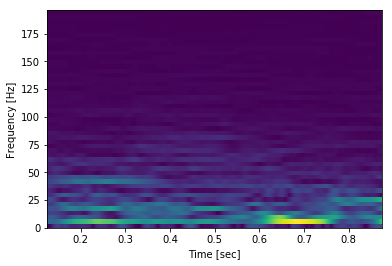

In [116]:
plt.pcolormesh(testt, testf, testx[:,:,0])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

#### Architecture

In [125]:
input_seq = Input(shape=input_size)

bn = BatchNormalization(axis = -1)(input_seq)

convolved = Conv2D(nb_filters, kernel_size=[3,5], padding="same", activation="elu")(bn)
convolvedbn = BatchNormalization(axis = -1)(convolved)
pooled = MaxPooling2D(pool_size = [2, 4])(convolvedbn)

convolved2 = Conv2D(nb_filters*4, kernel_size=[3,5], padding="same", activation="elu")(pooled)
convolved2bn = BatchNormalization(axis = -1)(convolved2)
pooled2 = MaxPooling2D(pool_size = [2, 4])(convolved2bn)

convolved3 = Conv2D(nb_filters*16, kernel_size=[3,3], padding="same", activation="elu")(pooled2)
convolved3bn = BatchNormalization(axis = -1)(convolved3)
pooled3 = MaxPooling2D(pool_size = [2, 4])(convolved3bn)

convolved4 = Conv2D(nb_filters*16, kernel_size=[3,3], padding="same", activation="elu")(pooled3)
convolved4bn = BatchNormalization(axis = -1)(convolved4)
pooled4 = MaxPooling2D(pool_size = [2, 4])(convolved4bn)

#convolved5 = Conv2D(nb_filters*16, kernel_size=[3,3], padding="same", activation="elu")(pooled4)
#convolved5bn = BatchNormalization(axis = -1)(convolved5)
#pooled5 = MaxPooling2D(pool_size = 4)(convolved5bn)

flat = Flatten()(pooled4)

dense1 = Dense(500, activation="elu", kernel_initializer="glorot_normal")(flat)
dense1bn = BatchNormalization(axis = -1)(dense1)
dense1do = Dropout(0.5)(dense1bn)

#dense2 = Dense(dense2_n, activation="relu")(dense1do)
#dense2bn = BatchNormalization()(dense2)
#dense2do = Dropout(do)(dense2bn)

out = Dense(1, activation='linear')(dense1do)

model = Model(inputs=input_seq, outputs=out)

model.compile(loss="mse", optimizer="adam", metrics=["mse"])

model.summary()

#nb_epoch = 100000


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 50, 1500, 4)       0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 50, 1500, 4)       16        
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 50, 1500, 10)      610       
_________________________________________________________________
batch_normalization_79 (Batc (None, 50, 1500, 10)      40        
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 25, 375, 10)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 25, 375, 40)       6040      
_________________________________________________________________
batch_normalization_80 (Batc (None, 25, 375, 40)       160       
__________

#### Early stopping

In [126]:
nb_samples = 1000
nb_val_samples = 500
nb_epochs = 200
patience = 5

batch_size = 32

earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(path_to_save_model, monitor='val_loss', verbose=1,
                               save_best_only=True, mode='auto', period=1)

#### Fit

In [127]:
history = model.fit_generator(data_generator(slice_len=slice_len, batch_size=batch_size, val=False, spec=True), 
                    steps_per_epoch=nb_samples, 
                    epochs = nb_epochs, 
                    callbacks=[earlyStopping, checkpointer], verbose=1, validation_steps=nb_val_samples, 
                    validation_data=data_generator(slice_len=slice_len, batch_size=batch_size, val=True, spec=True))

Epoch 1/200
3000/3000 [==============================] - 972s - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 3.3782 - val_mean_squared_error: 3.3782
Epoch 2/200
 169/3000 [>.............................] - ETA: 801s - loss: 5.9919e-04 - mean_squared_error: 5.9919e-04

KeyboardInterrupt: 

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


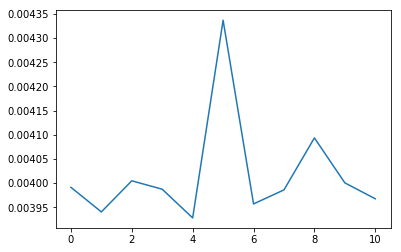

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())

plt.plot(history.history['val_loss'])


### Testing

In [39]:
model = load_model('testmodel2')

In [27]:
slice_len = 2000

pos = 2

In [28]:
np.array(input_size)

array([50,  5,  4])

In [32]:
slice_start = i
slice_end = slice_start + slice_len
slice_x_raw = raw_data_test[:,slice_start:slice_end].T
f, t, slice_x = signal.spectrogram(slice_x_raw, fs=2000, nperseg=1000, noverlap=750, axis = 0, mode='angle')

In [33]:
slice_x.shape

(501, 4, 5)

In [29]:
len_test = raw_data_test.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],input_size[0],input_size[1],input_size[2]])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x_raw = raw_data_test[:,slice_start:slice_end].T
    f, t, slice_x = signal.spectrogram(slice_x_raw, fs=2000, nperseg=1000, noverlap=750, axis = 0)
    slice_x = np.swapaxes(slice_x,1,2)
    slice_x = slice_x[:50,:,:]
    
    if pos==0:
        slice_y = mv_acc_test[0,slice_start]
    elif pos==1:
        slice_y = mv_acc_test[0,slice_mid]
    else:            
        slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1

In [49]:
tys_pred = model.predict(txs_0)

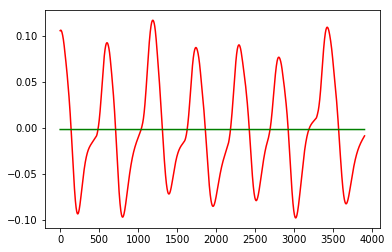

In [50]:
plt.plot(tys_0,'r')
plt.plot(tys_pred,'g')
plt.show()

### Prepare test data (spec)

In [ ]:
len_test = raw_data_test_spec.shape[1]
idxs = np.arange(0,len_test - slice_len,10)

txs_0 = np.zeros([idxs.shape[0],input_size[0],input_size[1],input_size[2]])
tys_0 = np.zeros([idxs.shape[0],1])

k = 0

for i in np.arange(0,len_test - slice_len,10):
    slice_start = i
    slice_end = slice_start + slice_len
    slice_x_raw = raw_data_test[:,slice_start:slice_end,:]
    
    if pos==0:
        slice_y = mv_acc_test[0,slice_start]
    elif pos==1:
        slice_y = mv_acc_test[0,slice_mid]
    else:            
        slice_y = mv_acc_test[0,slice_end]
    
    txs_0[k] = slice_x
    tys_0[k] = slice_y
    
    k = k+1